In [1]:
"""
Based on Vladimir Iglovikov' method: 
    https://www.kaggle.com/iglovikov/allstate-claims-severity/xgb-1114/discussion
"""
import pandas as pd
import numpy as np
import lightgbm as lgb
import time
import gc
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

print('loading train')
train = pd.read_csv('../../data/train.csv')
print('loading test')
test = pd.read_csv('../../data/test.csv')
test['loss'] = np.nan
joined = pd.concat([train, test])
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    con =2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 


def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))



/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


loading train
loading test


In [2]:
print('setting features')

for column in tqdm(list(train.select_dtypes(include=['object']).columns)):
    if train[column].nunique() != test[column].nunique():
        set_train = set(train[column].unique())
        set_test = set(test[column].unique())
        remove_train = set_train - set_test
        remove_test = set_test - set_train

        remove = remove_train.union(remove_test)
        def filter_cat(x):
            if x in remove:
                return np.nan
            return x

        joined[column] = joined[column].apply(lambda x: filter_cat(x), 1)

    joined[column] = pd.factorize(joined[column].values, sort=True)[0]


  0%|          | 0/116 [00:00<?, ?it/s]

setting features


100%|██████████| 116/116 [00:47<00:00,  2.42it/s]


In [3]:

train = joined[joined['loss'].notnull()]
test = joined[joined['loss'].isnull()]
print('log loss')
shift = 200
#y = train['loss']
y = np.log(train['loss'] + shift)
ids = test['id']
X = train.drop(['loss', 'id'], 1)
X_test = test.drop(['loss', 'id'], 1)

categorical_columns = [c for c in train.columns if ('cat' in c)]
categorical_columns

param = {'num_leaves': 200,
     'min_data_in_leaf': 9,
     'num_iterations': 50000,
     'num_thread': 4,
     'early_stopping_round': 200,
     'objective':'regression', # notice: the default value is regression
     'max_depth': -1,
     'learning_rate': 0.002,
     "boosting": "gbdt",
     "feature_fraction": 0.3149,
     "bagging_freq": 100,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 2019,
     "metric": 'l1',
     "lambda_l1": 0.1,
     "random_state": 2019,
     "verbosity": -1         
        }

log loss


In [ ]:
dct = {}

for i in range(100):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    time0 = round(time.time())
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("CV score: {:d}, {:<8.5f}".format(dpth, cv))
    
    dct[time0] = cv
    
    '''
    if len(lst_cv) < 10 or cv < lst_cv[9]:
        lst_cv = sorted(lst_cv + [cv])
        print('start predicting')
        prediction = np.exp(model.predict(X_test)) - shift
        print('preparing output')
        submission = pd.DataFrame()
        submission['loss'] = prediction
        submission['id'] = ids
        tm = str(time0) + '_' + str(round(cv*10))
        print('time: ',tm)
        submission.to_csv('submit_'+ tm +'.csv', index=False)
        #submission.to_csv('submit_'+ tm +'.csv.gz', compression='gzip', index=False)

        pck = open('pretrained_'+ tm +'.pkl', 'wb')
        pickle.dump(model, pck)
        pck.close()
    '''
    
top = sorted(dct.items(), key=lambda kv: kv[1], reverse = False)
print(top)

In [ ]:
# sort by the cv score

with open('output.txt', 'r') as f:
    i = 1
    dct = {}
    for line in f:
        if i%3 == 0: 
            [a, b] = line.split(' ')
            dct[int(a)] = float(b)
        i += 1
    print(dct)
    top = sorted(dct.items(), key=lambda kv: kv[1], reverse = False)
    print(top)

# Parameter tuning needed

### using max_depth = -1 and found overfitting
### for different random_state in train/valid split, got different CV scores from 1101 to 1140. (run the model 100 times, and record the random_state (t0) and cv scores.)

    time0 = round(time.time())
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)

top_10 = [(1549671965, 1101.2077218618037), (1549663495, 1107.54382844742), (1549683571, 1112.9327088227114), (1549663248, 1114.6283538761509), (1549669143, 1115.5866950100128), (1549675782, 1117.3292056910147), (1549682774, 1118.8597725723334), (1549680354, 1118.8780890290184), (1549683827, 1119.2518437220297), (1549681046, 1120.45433460368)]


# 1. Max_depth

### fixing random_state, change max_depth: 12 is enough; 
### Actually, I would use 7 considering the possible overfitting and complexity of model.


In [ ]:
lst_cv = [11328]
res = []

for i in range(10):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    #time0 = round(time.time())
    time0 = 1549681046 
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    #dpth = i + 13
    param['max_depth'] = 7
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("CV score: {:d}, {:<8.5f}".format(dpth, cv))
    res.append((dpth, cv))

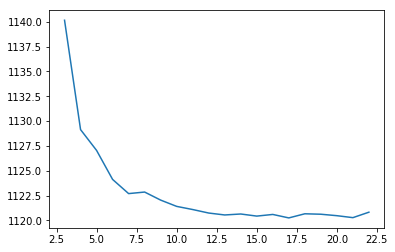

In [31]:
#time0 = 1549681046 #( 10th lowest CV)

res0 = [(3, 1140.152018451391),
 (4, 1129.1409075651584),
 (5, 1127.0458177248079),
 (6, 1124.1251423620197),
 (7, 1122.698941569006),
 (8, 1122.85474728398),
 (9, 1122.0444022389092),
 (10, 1121.4115469601754),
 (11, 1121.094762265545),
 (12, 1120.7415510162666)]
res1 = [(13, 1120.5481205408764),
 (14, 1120.6450444199415),
 (15, 1120.433970985074),
 (16, 1120.6001638882867),
 (17, 1120.2508547644234),
 (18, 1120.667209650019),
 (19, 1120.6219726481531),
 (20, 1120.4754970603399),
 (21, 1120.2780770667464),
 (22, 1120.8271911510733)]

import matplotlib.pyplot as plt  

x_dpth, y_cv = [], []
for i in range(10):
    x_dpth += [res0[i][0]]
    y_cv += [res0[i][1]]
for i in range(10):
    x_dpth += [res1[i][0]]
    y_cv += [res1[i][1]]
plt.plot(x_dpth, y_cv)
plt.show()

[(0, 0.0005, 1123.8092241002064), (1, 0.001, 1124.7920896750043), (2, 0.002, 1122.698941569006), (3, 0.004, 1123.9724659596116), (4, 0.008, 1124.5543607670265), (5, 0.016, 1125.6144338198803), (6, 0.032, 1128.7333370298704), (7, 0.064, 1126.6428994092362)]


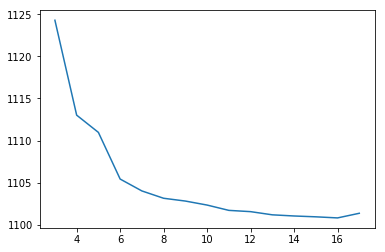

In [32]:
print(res)


import matplotlib.pyplot as plt  
#time0 = 1549671965 #(lowest CV)
res0 = [(3, 1124.3061063822117), (4, 1113.0174239036055), (5, 1110.9648352067504), (6, 1105.4157118781789), (7, 1104.0016524232772), (8, 1103.1292197374542), (9, 1102.7978270009464), (10, 1102.32113105329), (11, 1101.689194571118), (12, 1101.5382428224923)]
res1 = [(13, 1101.1599098171837),
 (14, 1101.022491828017),
 (15, 1100.9223597200016),
 (16, 1100.7920833262926),
 (17, 1101.3446330580416)]
x_dpth, y_cv = [], []
for i in range(10):
    x_dpth += [res0[i][0]]
    y_cv += [res0[i][1]]
for i in range(5):
    x_dpth += [res1[i][0]]
    y_cv += [res1[i][1]]
plt.plot(x_dpth, y_cv)
plt.show()

# 2. Learning_rate: 0.002 is good

In [27]:
res = []

for i in range(8):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    #time0 = round(time.time())
    #time0 = 1549671965 
    time0 = 1549681046
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    learning_rate = 0.0005 * (2**i)
    param['num_iterations'] = 100000
    param['max_depth'] = 7
    param['learning_rate'] = learning_rate
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("CV score: {:f}, {:<8.5f}".format(learning_rate, cv))
    res.append((i, learning_rate, cv))

##### round 0#####
spliting data
start training


/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.553745	valid_1's l1: 0.5496
[1000]	training's l1: 0.518592	valid_1's l1: 0.515006
[1500]	training's l1: 0.490199	valid_1's l1: 0.487297
[2000]	training's l1: 0.467361	valid_1's l1: 0.465224
[2500]	training's l1: 0.449575	valid_1's l1: 0.448276
[3000]	training's l1: 0.43506	valid_1's l1: 0.434703
[3500]	training's l1: 0.423718	valid_1's l1: 0.424308
[4000]	training's l1: 0.41442	valid_1's l1: 0.415897
[4500]	training's l1: 0.406861	valid_1's l1: 0.40922
[5000]	training's l1: 0.400688	valid_1's l1: 0.403879
[5500]	training's l1: 0.395528	valid_1's l1: 0.399509
[6000]	training's l1: 0.391304	valid_1's l1: 0.39603
[6500]	training's l1: 0.387695	valid_1's l1: 0.393123
[7000]	training's l1: 0.384607	valid_1's l1: 0.390653
[7500]	training's l1: 0.381913	valid_1's l1: 0.388545
[8000]	training's l1: 0.37964	valid_1's l1: 0.386849
[8500]	training's l1: 0.377653	valid_1's l1: 0.3854
[9000]	training's l1: 0.37589

[14000]	training's l1: 0.353271	valid_1's l1: 0.373781
[14500]	training's l1: 0.352641	valid_1's l1: 0.37364
[15000]	training's l1: 0.352045	valid_1's l1: 0.373524
[15500]	training's l1: 0.351465	valid_1's l1: 0.373405
[16000]	training's l1: 0.35086	valid_1's l1: 0.373293
[16500]	training's l1: 0.350263	valid_1's l1: 0.37319
[17000]	training's l1: 0.349676	valid_1's l1: 0.373098
[17500]	training's l1: 0.349116	valid_1's l1: 0.372992
[18000]	training's l1: 0.348579	valid_1's l1: 0.372907
[18500]	training's l1: 0.348047	valid_1's l1: 0.372837
[19000]	training's l1: 0.347496	valid_1's l1: 0.372765
[19500]	training's l1: 0.346933	valid_1's l1: 0.372703
[20000]	training's l1: 0.346413	valid_1's l1: 0.372644
[20500]	training's l1: 0.345881	valid_1's l1: 0.372582
[21000]	training's l1: 0.345374	valid_1's l1: 0.37253
[21500]	training's l1: 0.344875	valid_1's l1: 0.372481
[22000]	training's l1: 0.344333	valid_1's l1: 0.372407
[22500]	training's l1: 0.343799	valid_1's l1: 0.37234
[23000]	trainin

[(0, 0.0005, 1123.8092241002064), (1, 0.001, 1124.7920896750043), (2, 0.002, 1122.698941569006), (3, 0.004, 1123.9724659596116), (4, 0.008, 1124.5543607670265), (5, 0.016, 1125.6144338198803), (6, 0.032, 1128.7333370298704), (7, 0.064, 1126.6428994092362)]


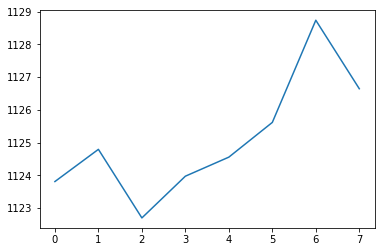

In [29]:
print(res)

x_lr, y_cv = [], []
for i in range(8):
    x_lr += [res[i][0]]
    y_cv += [res[i][2]]
plt.plot(x_lr, y_cv)
plt.show()

# 3. Grid_Param for LightGBM

In [ ]:
param = {'num_leaves': 200,
     'min_data_in_leaf': 9,
     'num_iterations': 50000,
     'num_thread': 4,
     'early_stopping_round': 200,
     'objective':'regression', # notice: the default value is regression
     'max_depth': 7,
     'learning_rate': 0.002,
     "boosting": "gbdt",
     "feature_fraction": 0.3149,
     "bagging_freq": 100,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 2019,
     "metric": 'l1',
     "lambda_l1": 0.1,
     "random_state": 2019,
     "verbosity": -1         
        }

In [42]:
from sklearn.model_selection import GridSearchCV

# params to search
gridParams = {
    'num_leaves': [10, 25, 50, 100, 200],
    'feature_fraction': [0.3, 0.5, 0.8], # same as 'colsample_bytree'
    'subsample': [0.7, 0.75, 0.8],
    'reg_alpha': [1, 1.2],
    'reg_lambda': [1,1.2, 1.4]
}

# classifier
mdl = lgb.LGBMRegressor(min_data_in_leaf=9,
     #num_iterations=10000,
     num_thread=4,
     #early_stopping_round=200,
     objective='regression', # notice: the default value is regression
     max_depth=7,
     learning_rate=0.002,
     boosting="gbdt",
     bagging_freq=100,
     bagging_fraction=0.8 ,
     bagging_seed=2019,
     metric='l1',
     lambda_l1= 0.1,
     random_state= 2019,
     verbosity= -1  
)

# to view the default params
mdl.get_params().keys()

# create the grid
grid = GridSearchCV(mdl, gridParams, verbose=0, cv=4, n_jobs=4) # n_jobs: number of threads

In [ ]:

grid.fit(X, y)

In [ ]:

print(grid.best_params_)
print(grid.best_score_)

#{'feature_fraction': 0.8, 'num_leaves': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.7} 
#0.14225891507699065

In [5]:
param = {'num_leaves': 200,
     'min_data_in_leaf': 9,
     'num_iterations': 50000,
     'num_thread': 4,
     'early_stopping_round': 200,
     'objective':'regression', # notice: the default value is regression
     'max_depth': 7,
     'learning_rate': 0.002,
     "boosting": "gbdt",
     "feature_fraction": 0.8, # new best value
     "bagging_freq": 100,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 2019,
     "metric": 'l1',
     "lambda_l1": 0.1,
     "random_state": 2019,
     "verbosity": -1         
        }

In [46]:
prediction = 0

for i in range(5):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    time0 = round(time.time())
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("CV score: {:d}, {:<8.5f}".format(i, cv))
    
    #dct[time0] = cv
    
    print('start predicting')
    prediction += np.exp(model.predict(X_test)) - shift
    
print('preparing output')
submission = pd.DataFrame()
submission['loss'] = prediction/5
submission['id'] = ids
tm = str(time0) + '_' + str(round(cv*10))
print('time: ',tm)
submission.to_csv('submit_'+ tm +'.csv', index=False)  # time:  1550106801_11419.0
#submission.to_csv('submit_'+ tm +'.csv.gz', compression='gzip', index=False)


##### round 0#####
spliting data
start training


/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.450968	valid_1's l1: 0.449823
[1000]	training's l1: 0.405446	valid_1's l1: 0.405324
[1500]	training's l1: 0.386396	valid_1's l1: 0.389259
[2000]	training's l1: 0.37584	valid_1's l1: 0.381734
[2500]	training's l1: 0.36914	valid_1's l1: 0.377682
[3000]	training's l1: 0.364318	valid_1's l1: 0.375236
[3500]	training's l1: 0.360754	valid_1's l1: 0.373843
[4000]	training's l1: 0.357887	valid_1's l1: 0.372808
[4500]	training's l1: 0.355485	valid_1's l1: 0.371998
[5000]	training's l1: 0.353235	valid_1's l1: 0.371479
[5500]	training's l1: 0.351354	valid_1's l1: 0.371075
[6000]	training's l1: 0.349629	valid_1's l1: 0.370772
[6500]	training's l1: 0.347962	valid_1's l1: 0.370557
[7000]	training's l1: 0.346442	valid_1's l1: 0.370333
[7500]	training's l1: 0.344947	valid_1's l1: 0.370181
[8000]	training's l1: 0.343476	valid_1's l1: 0.370006
[8500]	training's l1: 0.341974	valid_1's l1: 0.369888
[9000]	training's l1: 

In [10]:
prediction = 0
lst = []

rpt = 10
for i in range(rpt):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    time0 = round(time.time())
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    param['num_thread'] = 3
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("Round: {:d}, CV score: {:<8.5f}".format(i, cv))
    
    lst.append(cv)
    
    print('start predicting')
    prediction += np.exp(model.predict(X_test)) - shift
    
print('cv scores of {:d} rounds:'.format(rpt))
print(lst)
print('preparing output')
submission = pd.DataFrame()
submission['loss'] = prediction/rpt
submission['id'] = ids

time0 = round(time.time())
tm = str(time0) #+ '_' + str(round(cv*10))
print('time: ',tm)
#submission.to_csv('submit_'+ tm +'.csv', index=False)
submission.to_csv('submit_final.csv.gz', compression='gzip', index=False)


##### round 0#####
spliting data
start training


/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.450121	valid_1's l1: 0.454598
[1000]	training's l1: 0.404405	valid_1's l1: 0.412304
[1500]	training's l1: 0.385465	valid_1's l1: 0.395769
[2000]	training's l1: 0.374993	valid_1's l1: 0.387885
[2500]	training's l1: 0.368346	valid_1's l1: 0.383577
[3000]	training's l1: 0.363515	valid_1's l1: 0.381046
[3500]	training's l1: 0.359998	valid_1's l1: 0.3795
[4000]	training's l1: 0.357172	valid_1's l1: 0.378482
[4500]	training's l1: 0.354835	valid_1's l1: 0.377741
[5000]	training's l1: 0.352711	valid_1's l1: 0.377188
[5500]	training's l1: 0.350823	valid_1's l1: 0.376845
[6000]	training's l1: 0.348977	valid_1's l1: 0.376562
[6500]	training's l1: 0.347276	valid_1's l1: 0.376191
[7000]	training's l1: 0.345666	valid_1's l1: 0.376062
[7500]	training's l1: 0.344095	valid_1's l1: 0.375864
[8000]	training's l1: 0.34255	valid_1's l1: 0.375681
[8500]	training's l1: 0.341141	valid_1's l1: 0.375496
Early stopping, best it

[8500]	training's l1: 0.341178	valid_1's l1: 0.375041
Early stopping, best iteration is:
[8799]	training's l1: 0.340417	valid_1's l1: 0.374958
calculating CV
Round: 6, CV score: 1143.39074
start predicting
##### round 7#####
spliting data
start training
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.450372	valid_1's l1: 0.452702
[1000]	training's l1: 0.404403	valid_1's l1: 0.410877
[1500]	training's l1: 0.385407	valid_1's l1: 0.395131
[2000]	training's l1: 0.374803	valid_1's l1: 0.387394
[2500]	training's l1: 0.368483	valid_1's l1: 0.383613
[3000]	training's l1: 0.363615	valid_1's l1: 0.381179
[3500]	training's l1: 0.359777	valid_1's l1: 0.37963
[4000]	training's l1: 0.357144	valid_1's l1: 0.378856
[4500]	training's l1: 0.354565	valid_1's l1: 0.378167
[5000]	training's l1: 0.352605	valid_1's l1: 0.377805
[5500]	training's l1: 0.35063	valid_1's l1: 0.377458
[6000]	training's l1: 0.348737	valid_1's l1: 0.377148
[6500]	training's l1: 0.347119	valid_1

In [11]:
lst

[1144.0106842623654,
 1144.1926300113978,
 1142.0572855634732,
 1156.7381058895803,
 1140.2530286995382,
 1145.7051005758249,
 1143.3907438116294,
 1165.5578182560987,
 1117.0572494597684,
 1155.776761577437]

## retry with feature_fraction = 0.3149

In [12]:
prediction = 0
lst = []

rpt = 10
for i in range(rpt):
    print('##### round {:d}#####'.format(i))
    print('spliting data')
    time0 = round(time.time())
    x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size=0.1, random_state=time0)
    d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = categorical_columns)
    d_valid = lgb.Dataset(x_valid, label=y_valid, categorical_feature = categorical_columns)

    print('start training')
    num_round = 10000
    param['num_thread'] = 3
    param['feature_fraction'] = 0.3149
    model = lgb.train(param, d_train, num_round, valid_sets = [d_train, d_valid], verbose_eval=500)
    gc.collect()

    print('calculating CV')
    oof  = np.exp(model.predict(x_valid, num_iteration=model.best_iteration)) - shift
    cv = mean_absolute_error(np.exp(y_valid)-shift, oof)
    print("Round: {:d}, CV score: {:<8.5f}".format(i, cv))
    
    lst.append(cv)
    
    print('start predicting')
    prediction += np.exp(model.predict(X_test)) - shift
    
print('cv scores of {:d} rounds:'.format(rpt))
print(lst)
print('preparing output')
submission = pd.DataFrame()
submission['loss'] = prediction/rpt
submission['id'] = ids

time0 = round(time.time())
tm = str(time0) #+ '_' + str(round(cv*10))
print('time: ',tm)
#submission.to_csv('submit_'+ tm +'.csv', index=False)
submission.to_csv('submit_final_2.csv.gz', compression='gzip', index=False)


##### round 0#####
spliting data
start training


/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/Users/macssd/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 0.467452	valid_1's l1: 0.466163
[1000]	training's l1: 0.415135	valid_1's l1: 0.414803
[1500]	training's l1: 0.39186	valid_1's l1: 0.393244
[2000]	training's l1: 0.380164	valid_1's l1: 0.383457
[2500]	training's l1: 0.373504	valid_1's l1: 0.378448
[3000]	training's l1: 0.369103	valid_1's l1: 0.375614
[3500]	training's l1: 0.365939	valid_1's l1: 0.373925
[4000]	training's l1: 0.363405	valid_1's l1: 0.372783
[4500]	training's l1: 0.361475	valid_1's l1: 0.371959
[5000]	training's l1: 0.359744	valid_1's l1: 0.371303
[5500]	training's l1: 0.358144	valid_1's l1: 0.370765
[6000]	training's l1: 0.356746	valid_1's l1: 0.370427
[6500]	training's l1: 0.355405	valid_1's l1: 0.370088
[7000]	training's l1: 0.35407	valid_1's l1: 0.369767
[7500]	training's l1: 0.352822	valid_1's l1: 0.369471
[8000]	training's l1: 0.351659	valid_1's l1: 0.369232
[8500]	training's l1: 0.350472	valid_1's l1: 0.369052
[9000]	training's l1: 

[3000]	training's l1: 0.368633	valid_1's l1: 0.379558
[3500]	training's l1: 0.365463	valid_1's l1: 0.377898
[4000]	training's l1: 0.362986	valid_1's l1: 0.376742
[4500]	training's l1: 0.360864	valid_1's l1: 0.375867
[5000]	training's l1: 0.359061	valid_1's l1: 0.375261
[5500]	training's l1: 0.357475	valid_1's l1: 0.374767
[6000]	training's l1: 0.356123	valid_1's l1: 0.374396
[6500]	training's l1: 0.354883	valid_1's l1: 0.374098
[7000]	training's l1: 0.353577	valid_1's l1: 0.373849
[7500]	training's l1: 0.352286	valid_1's l1: 0.373587
[8000]	training's l1: 0.351106	valid_1's l1: 0.373378
[8500]	training's l1: 0.349932	valid_1's l1: 0.373175
[9000]	training's l1: 0.34884	valid_1's l1: 0.373053
[9500]	training's l1: 0.347701	valid_1's l1: 0.372875
[10000]	training's l1: 0.34665	valid_1's l1: 0.372754
[10500]	training's l1: 0.345575	valid_1's l1: 0.372615
[11000]	training's l1: 0.344565	valid_1's l1: 0.372537
[11500]	training's l1: 0.343546	valid_1's l1: 0.372447
[12000]	training's l1: 0.3

[7500]	training's l1: 0.352407	valid_1's l1: 0.372635
[8000]	training's l1: 0.351251	valid_1's l1: 0.372374
[8500]	training's l1: 0.350055	valid_1's l1: 0.372137
[9000]	training's l1: 0.348942	valid_1's l1: 0.371952
[9500]	training's l1: 0.347918	valid_1's l1: 0.371817
[10000]	training's l1: 0.346838	valid_1's l1: 0.371662
[10500]	training's l1: 0.345827	valid_1's l1: 0.371514
[11000]	training's l1: 0.344787	valid_1's l1: 0.371354
[11500]	training's l1: 0.343822	valid_1's l1: 0.371284
[12000]	training's l1: 0.342823	valid_1's l1: 0.371141
[12500]	training's l1: 0.341848	valid_1's l1: 0.371024
[13000]	training's l1: 0.340897	valid_1's l1: 0.370951
[13500]	training's l1: 0.339957	valid_1's l1: 0.370857
[14000]	training's l1: 0.339016	valid_1's l1: 0.37074
[14500]	training's l1: 0.338116	valid_1's l1: 0.370681
[15000]	training's l1: 0.337197	valid_1's l1: 0.3706
[15500]	training's l1: 0.336291	valid_1's l1: 0.370516
[16000]	training's l1: 0.335375	valid_1's l1: 0.370482
[16500]	training's

In [13]:
lst

[1130.6873928466473,
 1141.5700404319077,
 1144.110102961624,
 1132.2963517185367,
 1143.132798503863,
 1136.9136465284687,
 1123.9102218152577,
 1127.8065776874614,
 1147.6603642666412,
 1118.8836314714342]